# Descrizione

TEST 4: Classificazione Multiclasse con Split sui Sottoscalogrammi, senza bilanciamento e utilizzando ResNet50 con Early Stopping

# Librerie

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import glob
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast
import os
import csv
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from Dataset import CustomDataset

# Inizializzazione dei parametri

In [2]:
# Percorsi dei dataset di addestramento, validazione e test
train_dataset_path = r'/Users/massimo/PycharmProjects/EnderwaterSoundsClassification/Train_Bil'
val_dataset_path = r'/Users/massimo/PycharmProjects/EnderwaterSoundsClassification/Val_Norm'
test_dataset_path = r'/Users/massimo/PycharmProjects/EnderwaterSoundsClassification/Testing_Norm'

# Impostazione della dimensione del batch
batch_size = 128

# Numero di epoche di addestramento
num_epochs = 50

# Intervallo per il salvataggio dei checkpoint
checkpoint_interval = 1

# Parametri per l'early stopping
patience = 5
performance_drop_patience = 3

# Numero di passaggi di accumulazione del gradiente
gradient_accumulation_steps = 4

# Impostazione del learning rate
learning_rate = 0.001

# Directory per il salvataggio dei checkpoint
checkpoint_dir = r'/Users/massimo/PycharmProjects/EnderwaterSoundsClassification/Esperimento 1 Binary/EfficientNetB3_Binary'

#Path modello salvato
model_path = r'/Users/massimo/PycharmProjects/EnderwaterSoundsClassification/Esperimento 1 Binary/EfficientNetB3_Binary/EfficientNetB3_binary_classification.pth'

# Path risultati in file csv di Allenamento e Validazione 
df = pd.read_csv(r'C:\Users\biagi\PycharmProjects\UnderwaterSoundsClassification\Esperimento 4 Multiclasse\ResNet50\training_metrics.csv')

#Path file csv Test 
test_csv = r'C:\Users\biagi\PycharmProjects\UnderwaterSoundsClassification\Esperimento 4 Multiclasse\ResNet50\test_results.csv'

# Definizione della trasformazione per il preprocessing delle immagini
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Definizione della Classe CustomDataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))])
        self.data = []
        self.targets = []

        for idx, cls in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, cls)
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                if os.path.isfile(file_path):
                    self.data.append(file_path)
                    self.targets.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        target = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

# Funzioni per il Caricamento e il Salvataggio dei Checkpoint

In [3]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    start_epoch += 1
    metrics = checkpoint['metrics']
    return model, optimizer, start_epoch, metrics


def save_checkpoint(checkpoint_state, checkpoint_path):
    torch.save(checkpoint_state, checkpoint_path)

# Funzione per il Calcolo delle Metriche

In [4]:
def calculate_metrics(loader, model, device):
    model.eval()
    all_labels = []
    all_preds = []
    pbar = tqdm(loader, desc="Calcolo metriche")
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.round())
            pbar.update()

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

# Preparazione dei Dati

In [5]:

train_dataset = CustomDataset(train_dataset_path, transform=transform)
val_dataset = CustomDataset(val_dataset_path, transform=transform)

print(f"Classi trovate nel dataset di addestramento: {train_dataset.classes}")
print(f"Classi trovate nel dataset di validazione: {val_dataset.classes}")

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

Classi trovate nel dataset di addestramento: ['Allenamento_Non-Target_Bil2', 'Allenamento_Target_Bil']
Classi trovate nel dataset di validazione: ['Non-Target', 'Target']


# Inizializzazione del Modello

In [15]:
num_classes = len(train_dataset.classes)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.backends.cudnn.benchmark = True
scaler = GradScaler()


# Caricamento del Checkpoint

In [16]:
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

latest_checkpoint = glob.glob(os.path.join(checkpoint_dir, 'best_checkpoint.pth'))
if latest_checkpoint:
    latest_checkpoint = max(latest_checkpoint, key=os.path.getctime)
    model, optimizer, start_epoch, metrics = load_checkpoint(latest_checkpoint, model, optimizer)
else:
    model, optimizer, start_epoch, metrics = model, optimizer, 0, []

best_val_loss = float('inf')
patience_counter = 0
performance_drop_counter = 0
last_val_metrics = None

# Allenamento e Validazione con Early Stopping

In [ ]:
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_train_loss = 0.0
    optimizer.zero_grad()
    pbar_train = tqdm(train_loader, desc=f"Epoca {epoch + 1}/{num_epochs} - Addestramento")
    for step, (inputs, labels) in enumerate(pbar_train):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with autocast():
            outputs = model(inputs)
            train_loss = criterion(outputs, labels.float().view(-1, 1))
        scaler.scale(train_loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_train_loss += train_loss.item()
        pbar_train.set_postfix({'Loss': running_train_loss / (step + 1)})
    if (epoch + 1) % checkpoint_interval == 0:
        model.eval()
        running_val_loss = 0.0
        pbar_val = tqdm(val_loader, desc=f"Epoca {epoch + 1}/{num_epochs} - Valutazione")
        for inputs, labels in pbar_val:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.no_grad():
                with autocast():
                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels.float().view(-1, 1))
                running_val_loss += val_loss.item()
                pbar_val.set_postfix({'Val Loss': running_val_loss / len(val_loader)})

        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train_loader, model, device)
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_loader, model, device)
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)

        print(f"Epoca {epoch + 1}/{num_epochs} - "
              f"Loss Addestramento: {epoch_train_loss:.4f} - Acc Addestramento: {train_accuracy:.4f} - "
              f"Precision Addestramento: {train_precision:.4f} - Recall Addestramento: {train_recall:.4f} - "
              f"F1 Addestramento: {train_f1:.4f} - "
              f"Loss Valutazione: {epoch_val_loss:.4f} - Acc Valutazione: {val_accuracy:.4f} - "
              f"Precision Valutazione: {val_precision:.4f} - Recall Valutazione: {val_recall:.4f} - F1 Valutazione: {val_f1:.4f}")

        metrics.append({
            "epoch": epoch + 1,
            "train_loss": epoch_train_loss,
            "train_accuracy": train_accuracy,
            "train_precision": train_precision,
            "train_recall": train_recall,
            "train_f1": train_f1,
            "val_loss": epoch_val_loss,
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1": val_f1,
        })

        metrics_path = os.path.join(checkpoint_dir, f'training_metrics_epoch_{epoch + 1}.csv')
        with open(metrics_path, 'w', newline='') as csvfile:
            fieldnames = ['epoch', 'train_loss', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1',
                          'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for metric in metrics:
                writer.writerow(metric)

        print(f"Metriche per l'epoca {epoch + 1} salvate in: {metrics_path}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            performance_drop_counter = 0
            checkpoint_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': metrics
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'best_checkpoint.pth')
            save_checkpoint(checkpoint_state, checkpoint_path)
            print(f"Miglior checkpoint salvato in: {checkpoint_path}")
        else:
            patience_counter += 1

        if last_val_metrics:
            if (val_accuracy < last_val_metrics['val_accuracy'] and
                    val_precision < last_val_metrics['val_precision'] and
                    val_recall < last_val_metrics['val_recall'] and
                    val_f1 < last_val_metrics['val_f1']):
                performance_drop_counter += 1
                print(f"Prestazioni calate all'epoca {epoch + 1}, contatore di calo: {performance_drop_counter}")
            else:
                performance_drop_counter = 0

        last_val_metrics = {
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1": val_f1,
        }

        if patience_counter >= patience:
            print(f"Early stopping attivato dopo {epoch + 1} epoche senza miglioramenti")
            break

        if performance_drop_counter >= performance_drop_patience:
            print(f"Addestramento interrotto dopo {epoch + 1} epoche di calo delle prestazioni consecutive")
            break


# Salvataggio del Modello Finale

In [ ]:
model_path = os.path.abspath('EfficientNetB3_binary_classification.pth')
torch.save(model.state_dict(), 'EfficientNetB3_binary_classification.pth')

print(f"Modello salvato in: {model_path}")

# Creazione Grafici di Addestramento e Validazione

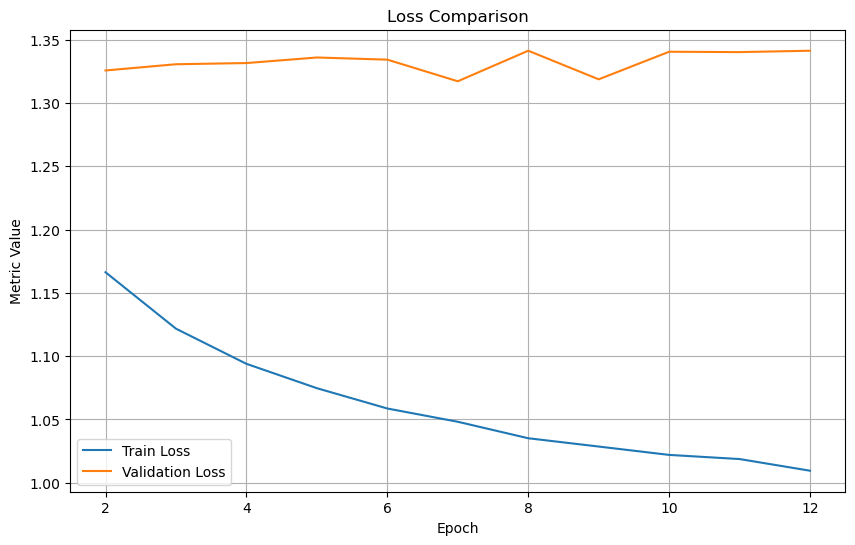

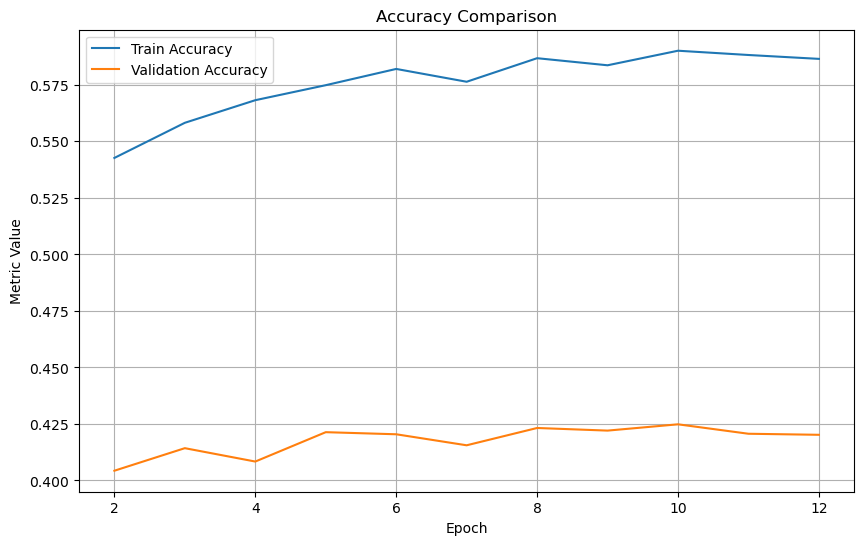

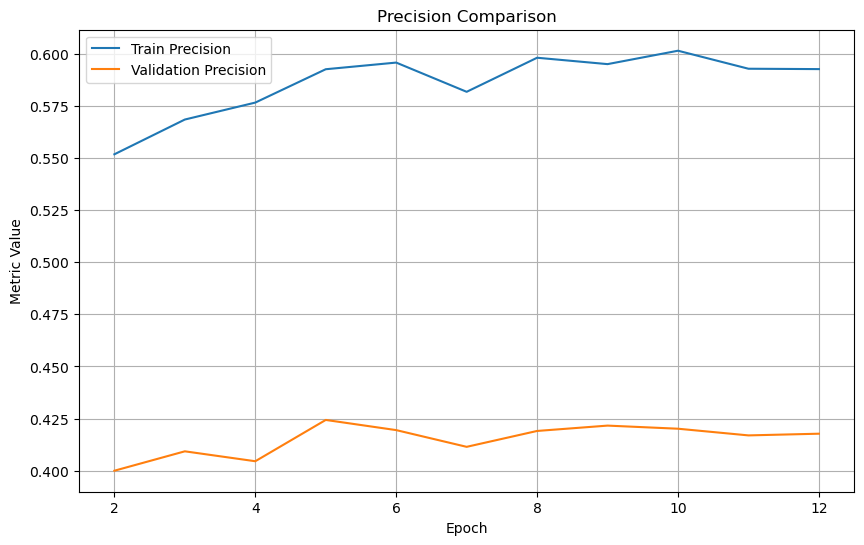

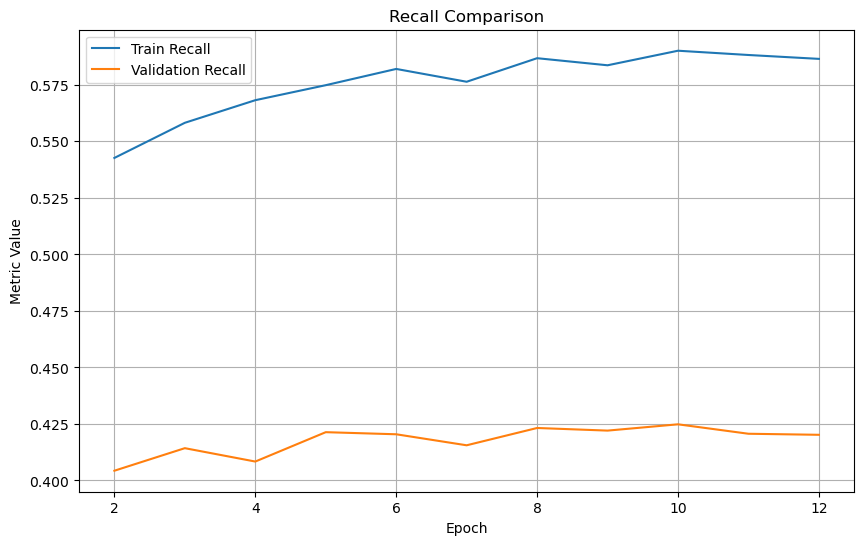

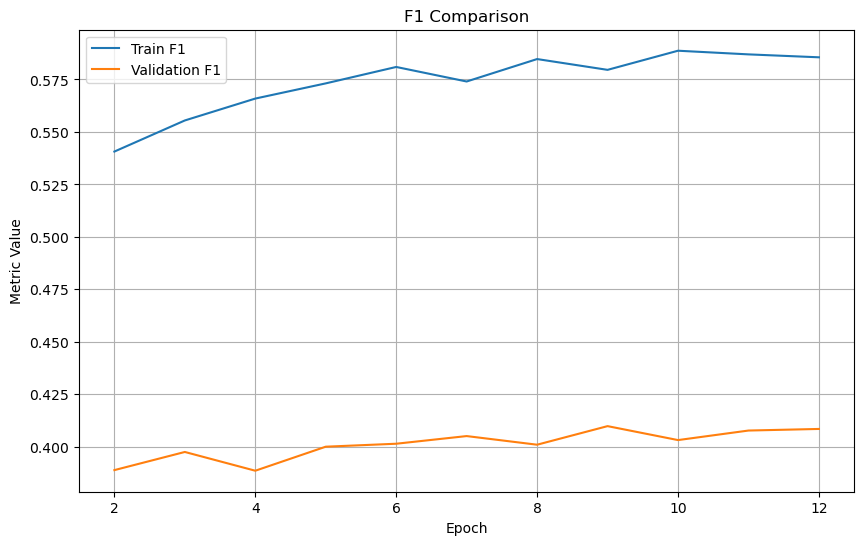

In [3]:
# Estrai le metriche di addestramento e validazione
train_metrics = ['train_loss', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1']
val_metrics = ['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1']

# Crea un grafico separato per ogni coppia di metriche
for train_metric, val_metric in zip(train_metrics, val_metrics):
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df[train_metric], label='Train ' + train_metric.split('_')[1].capitalize())
    plt.plot(df['epoch'], df[val_metric], label='Validation ' + val_metric.split('_')[1].capitalize())
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title(train_metric.split('_')[1].capitalize() + ' Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Testing

In [ ]:
def load_model(model_path, device):
    
    num_classes = len(train_dataset.classes)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
   
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

model = load_model(model_path, device)
model.eval()

criterion = nn.BCEWithLogitsLoss()
running_test_loss = 0.0
all_labels = []
all_outputs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        test_loss = criterion(outputs, labels.float().view(-1, 1))
        running_test_loss += test_loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

test_loss = running_test_loss / len(test_loader)
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(test_loader, model, device)

# Creazione del file CSV nella directory dei checkpoint
csv_output_path = os.path.join(checkpoint_dir, 'test_results.csv')
with open(csv_output_path, 'w', newline='') as csvfile:
    fieldnames = ['test_loss', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    })

print(f"Risultati del testing salvati in: {csv_output_path}")

# Creazione Grafici Testing

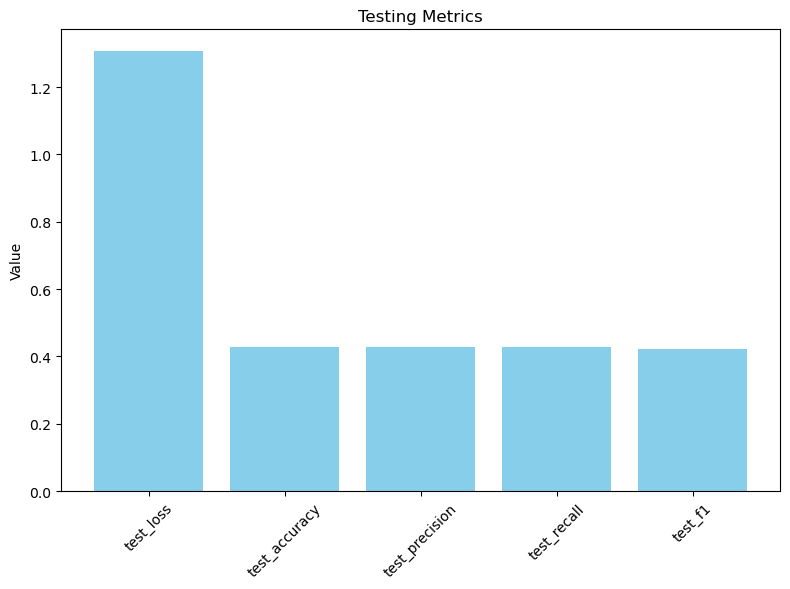

In [4]:
results = {}
with open(test_csv, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for key, value in row.items():
            results[key] = float(value)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot
ax.bar(results.keys(), results.values(), color='skyblue')

ax.set_ylabel('Value')
ax.set_title('Testing Metrics')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
